In [ ]:
# Hackathon 2017 - [Eat Play Work] Predictive Model


In [1]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")

import datetime, time, re, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC, SVR
from sklearn.decomposition import PCA, FactorAnalysis


In [2]:
brand_raw = pd.read_csv(r'C:\Users\User\Downloads\Hackathon\Challenge 4 - Prediction\cost_competition_combined3.csv', encoding = 'latin')
cotton_raw = pd.read_csv(r'C:\Users\User\Downloads\Hackathon\Challenge 4 - Prediction\Economic Data - Cotton Prices by Index.csv')
min_wage_raw = pd.read_csv(r'C:\Users\User\Downloads\Hackathon\Challenge 4 - Prediction\Economic Data - Minimum Wages by Country.csv')

In [3]:
# Check if need to cleanse the dataset
files = [brand_raw, cotton_raw, min_wage_raw]

for i in range(len(files)):
    print([i, files[i].isnull().values.any(), files[i].isnull().any().any(), files[i].empty, files[i].dropna().empty])

[0, True, True, False, True]
[1, False, False, False, False]
[2, False, False, False, False]


In [4]:
# Pre-processing data
brand01 = brand_raw
brand01.fillna(0, axis = 1, inplace = True)
brand01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36313 entries, 0 to 36312
Data columns (total 30 columns):
date              36313 non-null object
year              36313 non-null object
month             36313 non-null object
day               36313 non-null object
season            36313 non-null object
season2           36313 non-null object
brand             36313 non-null object
family            36313 non-null object
category          36313 non-null object
class             36313 non-null object
sub_class         36313 non-null object
fabric            36313 non-null object
fabric_desc       36313 non-null object
fabric type       36313 non-null float64
coo               36313 non-null object
gender            36313 non-null object
cost_cur          36313 non-null object
cost_art          36313 non-null float64
cost_cm           36313 non-null float64
cost_wash         36313 non-null float64
cost_trim         36313 non-null float64
cost_fab_unit     36313 non-null float64
cost_

In [5]:
brand01.head()

,date,year,month,day,season,season2,brand,family,category,class,...,cost_trim,cost_fab_unit,cost_yy,cost_fab,cost_hanger,cost_testing,cost_other,cost_fob,cost_landing,cost_style_est
0,1/13/2015 18:12,2015,1,13,Fall 2015,Fall,R,0,0,Layette,...,11.13,0.0,0.0,51.4500,2.1,0.21,0.0,94.5000,0.0,94.5000
1,1/14/2015 13:59,2015,1,14,Fall 2015,Fall,R,0,0,Layette,...,11.13,0.0,0.0,48.3525,2.1,0.21,0.0,93.0825,0.0,93.0825
2,1/14/2015 14:01,2015,1,14,Fall 2015,Fall,R,0,0,Layette,...,11.13,0.0,0.0,57.3300,2.1,0.21,0.0,100.3800,0.0,100.3800
3,1/14/2015 14:02,2015,1,14,Fall 2015,Fall,R,0,0,Layette,...,6.93,0.0,0.0,59.9760,2.1,0.21,0.0,91.8960,0.0,91.8960
4,1/14/2015 14:03,2015,1,14,Fall 2015,Fall,R,0,0,Layette,...,6.93,0.0,0.0,58.7160,2.1,0.21,0.0,88.9560,0.0,88.9560


In [6]:
# Casting
# brand01['date'] = brand01['date'].astype('float')
brand01['season'] = brand01['season'].astype('str')
brand01['season2'] = brand01['season2'].astype('str')
brand01['brand'] = brand01['brand'].astype('str')
brand01['family'] = brand01['family'].astype('str')
brand01['category'] = brand01['category'].astype('str')
brand01['season2'] = brand01['season2'].astype('str')
brand01['brand'] = brand01['brand'].astype('str')
brand01['family'] = brand01['family'].astype('str')
brand01['class'] = brand01['class'].astype('str')
brand01['sub_class'] = brand01['sub_class'].astype('str')
brand01['fabric'] = brand01['fabric'].astype('str')
brand01['fabric_desc'] = brand01['fabric_desc'].astype('str')
brand01['cost_cur'] = brand01['cost_cur'].astype('str')
brand01['coo'] = brand01['coo'].astype('str')
brand01['gender'] = brand01['gender'].astype('str')

In [7]:
# Get Dummies
case01 = brand01[['cost_style_est']]
temp01_season = pd.get_dummies(brand01['season2'], drop_first=True)
temp01_brand = pd.get_dummies(brand01['brand'], drop_first=True)
temp01_class = pd.get_dummies(brand01['class'], drop_first=True)
temp01_coo = pd.get_dummies(brand01['coo'], drop_first=True)
temp01_gender = pd.get_dummies(brand01['gender'], drop_first=True)
temp01_category = pd.get_dummies(brand01['category'], drop_first=True)
temp01_family = pd.get_dummies(brand01['family'], drop_first=True)
case01a = pd.concat([case01, temp01_family, temp01_category, temp01_season, temp01_brand, temp01_class, temp01_coo, temp01_gender], axis=1)
case01a.head()

,cost_style_est,ACCESSORIES,Apparel,SLEEPWEAR,ACCESSORIES MISC,ACCESSORY,Accessories,BAGS,BELTS,Bottoms,...,Vietnam,Boy,Boys,Girl,Girls,Men,Neutral,None,Uni,Women
0,94.5000,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,93.0825,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,100.3800,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,91.8960,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,88.9560,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [8]:
# Define X, y, split data

X01a = case01a.ix[:, case01a.columns != 'cost_style_est']
y01a = case01a[['cost_style_est']]
X01atrain, X01atest, y01atrain, y01atest = train_test_split(X01a, y01a, test_size = 0.8, random_state = 0)

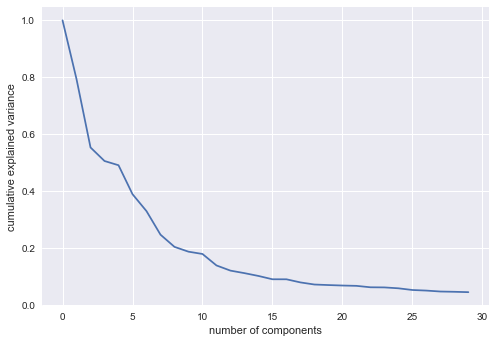

In [9]:
# Dimensionality Reduction

pca = PCA(n_components = 30)
pca.fit(X01atrain)
X01a_pca = pd.DataFrame(pca.components_,columns=list(X01atrain.columns.values))

# 1st 10 components already explains 80% of the variances
plt.plot(pca.explained_variance_ratio_ / max(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

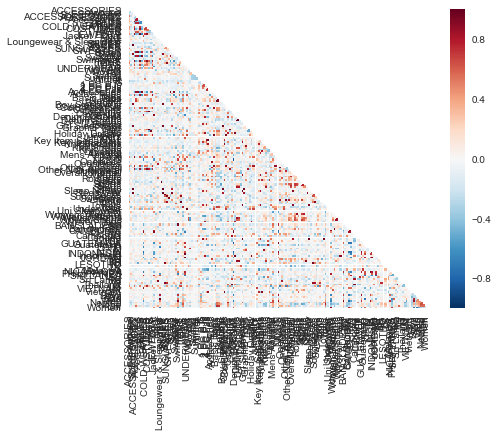

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [10]:
# To know the columns of components
n_components = 30
pc_component = pd.DataFrame(pca.components_,columns=list(X01atrain.columns.values),
                   index = ['PC-{0}'.format(s) for s in range(1 ,n_components + 1)])
corr = pc_component.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True)

fig, ax = plt.subplots(figsize=(50,50))         # Sample figsize in inches
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)

In [11]:
n_components = 30

# Use this transformed dataframe to train the model
#X01a_transform = pd.DataFrame(pca.transform(X01atrain), columns=['PC-{0}'.format(s) for s in range(1 ,n_components + 1)])

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X01atrain)

X_train_pca = pca.transform(X01atrain)
X_test_pca = pca.transform(X01atest)

In [12]:
# Grid search for the best fit

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
clf = GridSearchCV(SVR(kernel='rbf'), param_grid)
clf = clf.fit(X_train_pca, y01atrain)

In [ ]:
print("Best estimator found by grid search:")
print(clf.best_estimator_, clf.best_score_)
bp, bs = clf.best_params_,clf.best_score_

In [ ]:
# Use the best parameter to retrain the SVR model w/ result

svr_rbf = SVR(kernel='rbf', C=bp['C'], gamma=0.005)
y_rbf = svr_rbf.fit(X = X01a_transform, y = y01atrain).predict(X_test_pca)
# y_fitted = pd.DataFrame(y_rbf, columns = ['Fitted'])

In [ ]:
loss = [y01atest.values.flatten() - y_rbf]
np.sum(loss)

#X_train_pca = pca.transform(X01atrain)
#X_projected = pca.inverse_transform(X_train_pca)